In [3]:
import pandas as pd
from pandas import DataFrame
df=pd.read_csv("A1.csv",names=['id','label'])
df1_T=(df[0:49])
df1_V=(df[49:74])
training_set = pd.read_csv('A1.csv').values
#A=training_set[:,1]
#Train_L=A[0:49]
#print(df1_T)
#pri(df1_V)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
train_generator = train_datagen.flow_from_dataframe(
        dataframe=df1_T,
        directory='A1_LCC/A1_T',
        x_col="id",
        y_col="label",
        shuffle=True,
        target_size=(320, 320),
        batch_size=6,
        class_mode="raw")
valid_generator=train_datagen.flow_from_dataframe(
                dataframe=df1_V,
                directory='A1_LCC/A1_V',
                x_col="id",
                y_col="label",
               
                batch_size=6,
                #seed=49,
                shuffle=True,
                class_mode="raw",
                target_size=(320,320))

Found 49 validated image filenames.
Found 25 validated image filenames.


In [5]:
from keras.applications.resnet50 import ResNet50
res_model = ResNet50(include_top=False,weights='imagenet',input_shape=(320,320,3))

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [6]:
from keras import Model, layers
from keras import regularizers
from keras.optimizers import Adam
#model=model.include_top=False
#model.summary()
#model=ResNet50()
#model.summary()
x = res_model.output
print(x)
x = layers.MaxPooling2D()(x)
print(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
leaf_pred =layers. Dense(1)(x)
model = Model(inputs = res_model.input, outputs = leaf_pred)
model.compile(optimizer=Adam(lr=0.0001), loss= 'mse',metrics=['accuracy'])

Tensor("activation_49/Relu:0", shape=(None, 10, 10, 2048), dtype=float32)
Tensor("max_pooling2d_2/MaxPool:0", shape=(None, 5, 5, 2048), dtype=float32)


In [7]:
import keras
from keras.callbacks import EarlyStopping
csv_logger = keras.callbacks.CSVLogger('training.log', separator=',')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.03, mode='min', patience=8)#,restore_best_weights=True)

In [8]:
step_size_train=train_generator.n//train_generator.batch_size
step_size_valid=valid_generator.n//valid_generator.batch_size
history=model.fit_generator(generator=train_generator,
                    steps_per_epoch=step_size_train,
                    validation_data=valid_generator,
                    validation_steps=step_size_valid,
                    #steps_per_epoch=1,
                    epochs=50,
                    callbacks= [csv_logger,early_stop])

Epoch 1/50
8/8 [==============================] - 38s 5s/step - loss: 194.4338 - accuracy: 0.0233 - val_loss: 119.8879 - val_accuracy: 0.0000e+00
Epoch 2/50
8/8 [==============================] - 6s 797ms/step - loss: 30.2048 - accuracy: 0.0930 - val_loss: 189.9039 - val_accuracy: 0.0000e+00
Epoch 3/50
8/8 [==============================] - 7s 833ms/step - loss: 17.8677 - accuracy: 0.1250 - val_loss: 170.3061 - val_accuracy: 0.0000e+00
Epoch 4/50
8/8 [==============================] - 6s 712ms/step - loss: 10.4553 - accuracy: 0.2632 - val_loss: 160.6783 - val_accuracy: 0.0000e+00
Epoch 5/50
8/8 [==============================] - 6s 732ms/step - loss: 11.3660 - accuracy: 0.1395 - val_loss: 224.6962 - val_accuracy: 0.0000e+00
Epoch 6/50
8/8 [==============================] - 6s 750ms/step - loss: 11.7114 - accuracy: 0.2791 - val_loss: 138.6510 - val_accuracy: 0.0000e+00
Epoch 7/50
8/8 [==============================] - 7s 877ms/step - loss: 11.5938 - accuracy: 0.0833 - val_loss: 137.8466

In [24]:
print(history.history.keys())

dict_keys(['val_accuracy', 'loss', 'val_loss', 'accuracy'])


In [9]:
import numpy as np
acc_avg=np.average(history.history['accuracy'])
print(acc_avg)
mse_avg=np.average(history.history['loss'])
print(mse_avg)

0.18249507
20.441388346361773


In [20]:
from keras.preprocessing import image
import os
path = 'DL-Project/data/A1/plant002_rgb.png' 
img = image.load_img(path, target_size=(320, 320))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x=x/255
#images = np.vstack([x])
pred= model.predict(x, batch_size=64)
print(pred)

[[18.557566]]


In [11]:
def sliding_window(img, size, step):
    xall = np.expand_dims(img, axis=0)
    for y in range(0, 280, step):
        for x in range(0, 280, step):
            x1n = np.copy(img)
            x1n = np.expand_dims(x1n, axis=0)
            x1n[:,y:y + size, x:x + size]=0
            xall= np.concatenate((xall, x1n), axis=0)
    return xall[1:len(xall)]

In [23]:
pic1_window = sliding_window(img, 60, 10)
pic1_pred = np.round(model.predict(pic1_window))
#print(pic1_pred.shape)
pic1_re = np.reshape(pic1_pred, (28,28))
print(pic1_re.shape)
pic1_re_flip = np.fliplr(pic1_re)

(28, 28)


In [18]:
#pic1_window.shape
#plt.imshow(pic1_window)

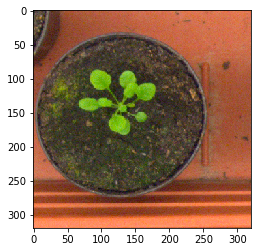

In [15]:
#import cv2
#path = 'DL-Project/data/A1/plant002_rgb.png'
#im=cv2.imread(path)
#cv2.imshow('Image',im)
plt.imshow(img)

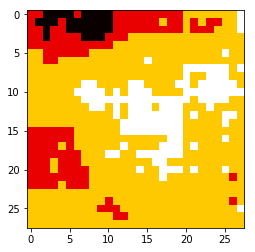

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
cax = ax.imshow(pic1_re_flip, cmap='hot')
#ax.axes.get_xaxis().set_ticks([])
#ax.axes.get_yaxis().set_ticks([])
#ticks=[7,6,5,4,3]
#cbar = fig.colorbar(cax, ticks=ticks, boundaries=[4,5,6,7,8])
#loc = [7.5, 6.5, 5.5, 4.5]
#cbar.set_ticks(loc)
#cbar.ax.set_yticklabels(['GT', '-1', '-2', '-3'])
#plt.show()

In [21]:
import cv2
for i in range(len(model.layers)):
	layer = model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)
#res5c_branch2c (Conv2D) 

1 conv1_pad (None, 326, 326, 3)
2 conv1 (None, 160, 160, 64)
3 bn_conv1 (None, 160, 160, 64)


In [24]:
from matplotlib import pyplot

In [25]:
model= Model(inputs = res_model.input, outputs = res_model.output)
#print(res_model.output)
#res_model.summary
feature_maps=np.round(model.predict(x))

In [35]:
#pic1_re = np.reshape(feature_maps, (28,28))
#pic1_re_flip = np.fliplr(pic1_re)


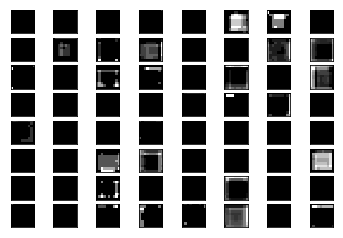

In [31]:
#from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
layers_name = ['activation_1']
# load the model
#model = VGG16()
outputs = [
    layer.output for layer in model.layers
    if layer.name in layers_name
]
model.layers
#print(outputs)
# redefine model to output right after the first hidden layer
#model = Model(inputs=res_model.input, outputs=outputs)
#model.summary()
# load the image with the required shape
#img = load_img('DL-Project/data/A1/plant001_rgb.png', target_size=(320, 320))
# convert the image to an array
#img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
#img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the model)
#img = img/255
#model.compile(optimizer='adam', loss='categorical_crossentropy')
# get feature map for first hidden layer
#feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

In [34]:
#from keract import get_activations